
```
author : "Amit Yadav"
email : "amitech90@gmail.com"
github : "[warriorwizard](https://github.com/warriorwizard)"

```


In [1]:
import os
import cv2
import tensorflow as tf
import cv2
import json
import numpy as np
from matplotlib import pyplot as plt

# Loading images

In [3]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [4]:
train_images = tf.data.Dataset.list_files('data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (250,250)))
train_images = train_images.map(lambda x: x/255)

In [5]:
test_images = tf.data.Dataset.list_files('data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (250,250)))
test_images = test_images.map(lambda x: x/255)

In [6]:
val_images = tf.data.Dataset.list_files('data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (250,250)))
val_images = val_images.map(lambda x: x/255)

# Preparing the labels

In [7]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
    return [label['keypoint']]
    # return [label['hand_pts']]

In [8]:
train_labels = tf.data.Dataset.list_files('data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [9]:
test_labels = tf.data.Dataset.list_files('data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [10]:
val_labels = tf.data.Dataset.list_files('data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))


# Combining Labels and Images

In [11]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(16)
train = train.prefetch(4)

In [12]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(16)
test = test.prefetch(4)

In [13]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(16)
val = val.prefetch(4)

# Visualizing a sample image and its keypoints

In [14]:
data_samples = train.as_numpy_iterator()

In [15]:
res = data_samples.next()

In [16]:
# cv2.circle??
res[0][0].shape

(250, 250, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 0, Keypoint 0: x=89.875, y=128.625
Image 0, Keypoint 1: x=113.6875, y=128.125
Image 0, Keypoint 2: x=85.125, y=144.75
Image 0, Keypoint 3: x=107.8125, y=146.375
Image 1, Keypoint 0: x=140.25, y=122.375
Image 1, Keypoint 1: x=154.75, y=101.5625
Image 1, Keypoint 2: x=154.25, y=137.0
Image 1, Keypoint 3: x=166.375, y=116.6875
Image 2, Keypoint 0: x=94.5, y=107.8125
Image 2, Keypoint 1: x=113.25, y=90.625
Image 2, Keypoint 2: x=105.875, y=121.375
Image 2, Keypoint 3: x=123.4375, y=108.875
Image 3, Keypoint 0: x=144.875, y=115.125
Image 3, Keypoint 1: x=162.875, y=134.375
Image 3, Keypoint 2: x=134.375, y=126.0625
Image 3, Keypoint 3: x=150.0, y=146.375


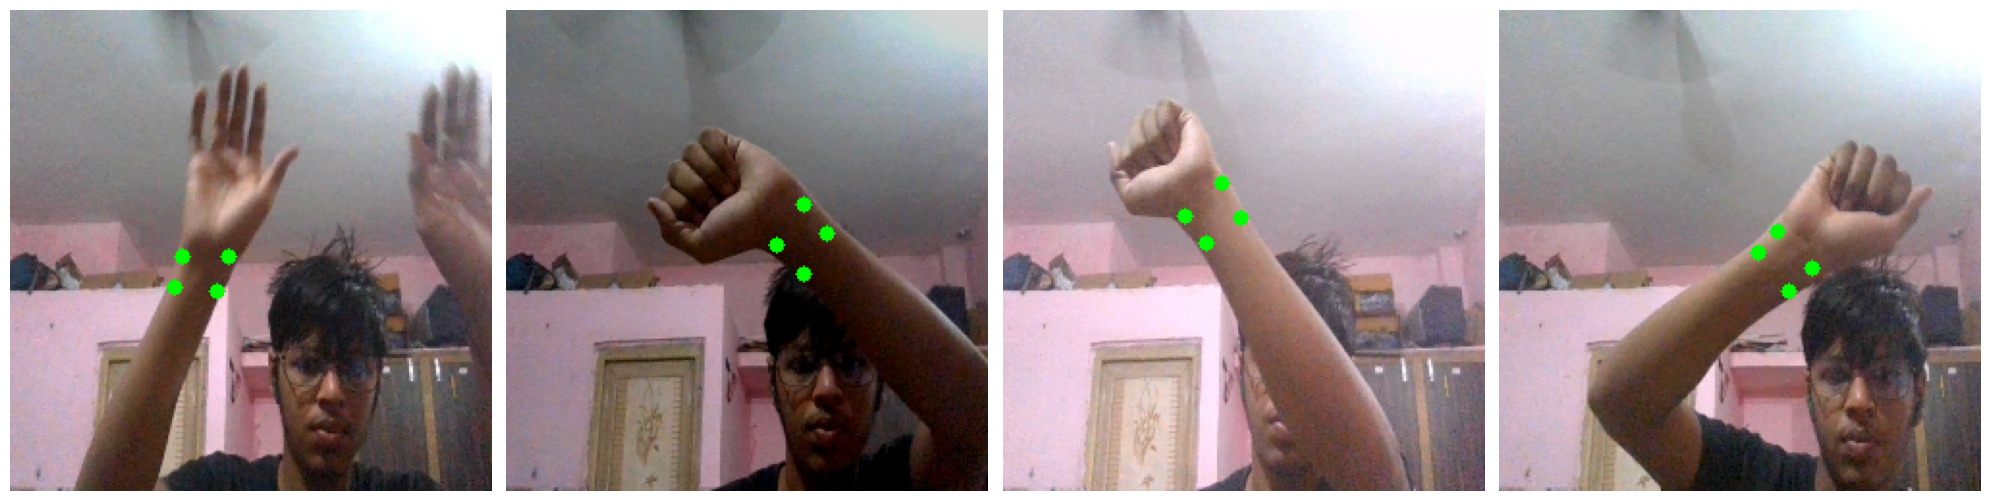

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx in range(4): 
    sample_image = np.copy(res[0][idx])
    sample_coords = res[1][0][idx]

    # Unnormalize the coordinates for a 250x250 image
    # coords = sample_coords * 250
    coords = sample_coords

    # Iterate over the coordinates in pairs (x, y)
    for i in range(0, len(coords), 2):
        x = coords[i]
        y = coords[i+1]
        
        # Print the coordinates
        print(f"Image {idx}, Keypoint {i//2}: x={x}, y={y}")

        # Check if coordinates are valid (not infinity) and within image bounds
        # if not (np.isinf(x) or np.isinf(y)) and 0 <= x < 250 and 0 <= y < 250:
        #     cv2.circle(sample_image, (int(x), int(y)), 3, (0, 255, 0), -1)

        # mark the coordinates on the image
        cv2.circle(sample_image, (int(x), int(y)), 4, (0, 255, 0), -1)
    
    # Display the image with keypoints
    ax[idx].imshow(sample_image)
    ax[idx].axis('off')  # Hide the axis

plt.tight_layout()
plt.show()



# Build the Model

### Creating Neural Network

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Reshape, Dropout
from tensorflow.keras.applications import ResNet152V2

In [19]:
# model = Sequential([
#     Input(shape=(250,250,3)), 
#     ResNet152V2(include_top=False, input_shape=(250,250,3)),
#     Conv2D(512, 3, padding='same', activation='relu'),
#     Conv2D(512, 3, padding='same', activation='relu'),
#     Conv2D(256, 3, 2, padding='same', activation='relu'),
#     Conv2D(256, 2, 2, activation='relu'),
#     Dropout(0.05),
#     Conv2D(4, 2, 2),
#     Reshape((4,))
# ])

In [2]:
# make a model with 42 output points

model = Sequential([
    Input(shape=(250,250,3)), 
    ResNet152V2(include_top=False, input_shape=(250,250,3)),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(512, 3, padding='same', activation='relu'),
    Conv2D(256, 3, 2, padding='same', activation='relu'),
    Conv2D(256, 2, 2, activation='relu'),
    Dropout(0.05),
    Conv2D(8, 2, 2),
    Reshape((8,))
])

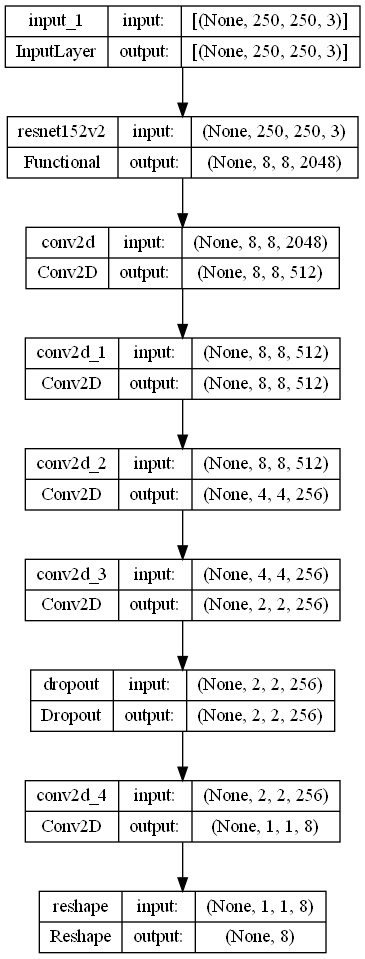

In [3]:
# plot the architecture

from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')


In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 conv2d (Conv2D)             (None, 8, 8, 512)         9437696   
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 512)         2359808   
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 256)         1179904   
                                                                 
 conv2d_3 (Conv2D)           (None, 2, 2, 256)         262400    
                                                                 
 dropout (Dropout)           (None, 2, 2, 256)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 1, 8)           8

# Setup the model with an optimizer and a loss function

In [22]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, decay=0.0007)
# loss = tf.keras.losses.MeanSquaredError()
loss = tf.keras.losses.MeanSquaredError()

In [23]:
model.compile(optimizer, loss)

# Sense check prediction

In [24]:
X, y = train.as_numpy_iterator().next()


In [25]:
# X.shape, y.shape

In [26]:
scores = model.predict(X)

1/1 [==============================] - 3s 3s/step


In [27]:
scores

array([[-4.13685977e-01, -4.27136511e-01, -4.41055715e-01,
         1.45588541e+00, -2.03820065e-01,  2.80084074e-01,
        -2.68242776e-01, -1.37511969e-01],
       [-4.69758928e-01,  2.41406143e-01, -7.37433672e-01,
         1.54359829e+00,  3.81498873e-01, -5.06390631e-02,
         3.32819581e-01,  3.23767930e-01],
       [-4.33025301e-01,  9.70043987e-02, -8.84950995e-01,
         1.22860003e+00,  1.21924877e-02, -9.60313380e-01,
         3.53330523e-01,  5.15002728e-01],
       [ 3.15087736e-01,  1.36500925e-01, -1.12381136e+00,
         9.63044167e-01, -8.09473276e-01,  5.83694875e-01,
         6.56062663e-01,  8.67342353e-01],
       [-3.62199932e-01, -1.06015265e-01, -1.99672937e-01,
         1.11525440e+00, -7.07015395e-01,  4.13920254e-01,
         2.24193186e-01,  1.79069489e-02],
       [ 4.82019275e-01,  5.35814166e-02, -8.91830325e-01,
         7.61236668e-01, -6.14913940e-01,  7.26421714e-01,
         1.99579537e-01,  4.69344854e-01],
       [-3.52360249e-01,  4.758372

# Train the model 

In [28]:
# Train for 10 epochs
hist = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10


223/223 [==============================] - 953s 4s/step - loss: 2520.2249 - val_loss: 4503.1401
Epoch 2/10
223/223 [==============================] - 929s 4s/step - loss: 156.4868 - val_loss: 25.1383
Epoch 3/10
223/223 [==============================] - 901s 4s/step - loss: 56.7201 - val_loss: 42.0998
Epoch 4/10
223/223 [==============================] - 930s 4s/step - loss: 40.8225 - val_loss: 19.4881
Epoch 5/10
223/223 [==============================] - 1063s 5s/step - loss: 29.1529 - val_loss: 14.6862
Epoch 6/10
223/223 [==============================] - 965s 4s/step - loss: 30.2880 - val_loss: 67.3125
Epoch 7/10
223/223 [==============================] - 973s 4s/step - loss: 25.1309 - val_loss: 13.4599
Epoch 8/10
223/223 [==============================] - 973s 4s/step - loss: 24.1200 - val_loss: 6.5165
Epoch 9/10
223/223 [==============================] - 958s 4s/step - loss: 22.8782 - val_loss: 121.0076
Epoch 10/10
223/223 [==============================] - 996s 4s/step - loss: 29

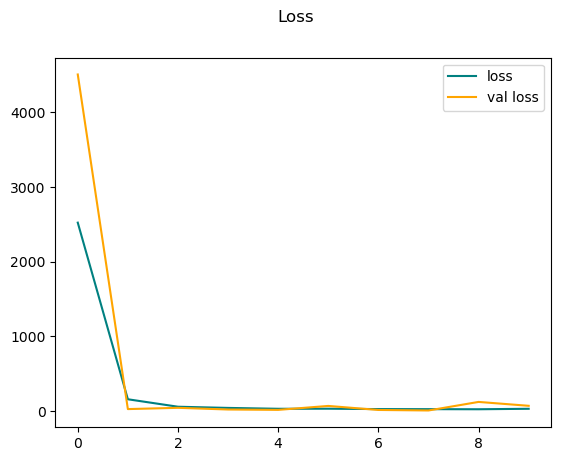

In [29]:
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val loss')
plt.suptitle('Loss')
plt.legend()
plt.show()

# Saving the Model 



In [64]:
model.save('wrist_estimator_10_epochs.h5')

# Load the model

In [77]:
from tensorflow import keras
model = keras.models.load_model('wrist_estimator_10_epochs.h5')

In [78]:
# Making prediction 

test_data = test.as_numpy_iterator()

In [79]:
test_sample = test_data.next()

In [80]:
yhat = model.predict(test_sample[0])

1/1 [==============================] - 3s 3s/step


In [81]:
yhat

array([[163.73904 , 105.24499 , 176.13756 , 128.66275 , 145.5463  ,
        119.108925, 157.88782 , 140.00543 ],
       [141.18344 ,  88.73589 , 162.5466  , 106.657135, 126.27447 ,
        107.16621 , 144.02347 , 124.49923 ],
       [ 57.52293 , 118.2733  ,  79.185646, 120.186584,  51.168922,
        139.81995 ,  74.8112  , 139.72195 ],
       [155.52    , 125.33241 , 169.42822 , 101.701935, 169.34402 ,
        140.96373 , 182.34874 , 118.62896 ],
       [156.61649 , 122.224525, 172.62187 , 143.6478  , 142.10344 ,
        134.29932 , 155.9793  , 154.76343 ],
       [ 58.365913, 117.83296 ,  79.672165, 119.11653 ,  51.99476 ,
        139.04752 ,  76.01853 , 139.22903 ],
       [ 97.636444, 114.144966, 117.574425, 113.89037 ,  88.58778 ,
        132.51724 , 111.40146 , 132.95949 ],
       [163.79721 , 105.30919 , 176.13712 , 128.7503  , 145.59335 ,
        119.14372 , 157.88579 , 140.05798 ],
       [ 97.23311 , 114.53291 , 117.25178 , 114.19113 ,  88.129654,
        133.07472 , 111.2933

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sample coords [163.73904  105.24499  176.13756  128.66275  145.5463   119.108925
 157.88782  140.00543 ]
Image 0, Keypoint 0: x=163.73904418945312, y=105.24498748779297
Image 0, Keypoint 1: x=176.13755798339844, y=128.66275024414062
Image 0, Keypoint 2: x=145.54629516601562, y=119.10892486572266
Image 0, Keypoint 3: x=157.8878173828125, y=140.00543212890625
sample coords [141.18344   88.73589  162.5466   106.657135 126.27447  107.16621
 144.02347  124.49923 ]
Image 1, Keypoint 0: x=141.18344116210938, y=88.73589324951172
Image 1, Keypoint 1: x=162.54660034179688, y=106.65713500976562
Image 1, Keypoint 2: x=126.27446746826172, y=107.16620635986328
Image 1, Keypoint 3: x=144.02346801757812, y=124.49922943115234
sample coords [ 57.52293  118.2733    79.185646 120.186584  51.168922 139.81995
  74.8112   139.72195 ]
Image 2, Keypoint 0: x=57.52293014526367, y=118.27330017089844
Image 2, Keypoint 1: x=79.1856460571289, y=120.18658447265625
Image 2, Keypoint 2: x=51.168922424316406, y=139.819

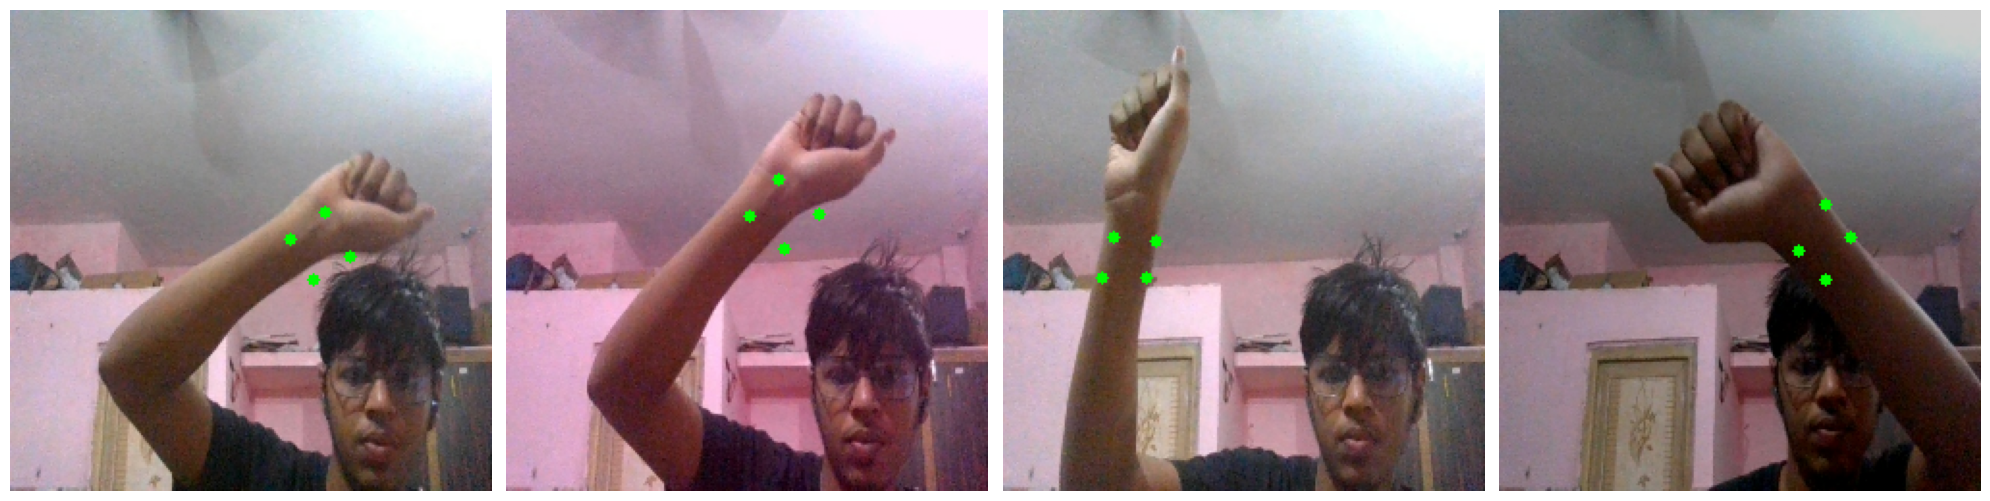

In [82]:

fig, ax = plt.subplots(ncols=4, figsize=(20,20))

for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[idx]

    # Unnormalize the coordinates for a 250x250 image
    # coords = sample_coords * 250
    print('sample coords', sample_coords)

    # Iterate over the coordinates in pairs (x, y)
    for i in range(0, len(sample_coords), 2):
        x = sample_coords[i]
        y = sample_coords[i+1]
        
        # Print the coordinates
        print(f"Image {idx}, Keypoint {i//2}: x={x}, y={y}")

        # Check if coordinates are valid (not infinity) and within image bounds
        # if not (np.isinf(x) or np.isinf(y)) and 0 <= x < 250 and 0 <= y < 250:
        cv2.circle(sample_image, (int(x), int(y)), 3, (0, 255, 0), -1)
    
    # Display the image with keypoints
    ax[idx].imshow(sample_image)
    ax[idx].axis('off')  # Hide the axis

plt.tight_layout()
plt.show()


In [83]:
# # Real time prediction

# cap = cv2.VideoCapture(0)
# while cap.isOpened():
#     _ , frame = cap.read()
    
#     # frame = frame[50:500,50:500,:] 
#     rgb_img = frame
#     # rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
#     resized = cv2.resize(rgb_img, (250,250))
    
#     # yhat = model.predict(np.expand_dims(resized/255,0))
#     # sample_coords = yhat[0,:4]
#     coords = model.predict(np.expand_dims(resized/255,0))[0]
#     # print('sample coords', sample_coords)

#     # for coord in sample_coords:
#     #     # print(coord)
#     #     # cv2.circle(resized, tuple((int(coord[0]),int(coord[1]))), 5, (255,0,0), -1)
#     #     cv2.circle(sample_image, (int(x), int(y)), 4, (0, 255, 0), -1)

#     for i in range(0, len(coords), 2):
#         x = coords[i]
#         y = coords[i+1]
        
#         # Print the coordinates
#         # print(f"Image {idx}, Keypoint {i//2}: x={x}, y={y}")

#         # Check if coordinates are valid (not infinity) and within image bounds
#         # if not (np.isinf(x) or np.isinf(y)) and 0 <= x < 250 and 0 <= y < 250:
#         #     cv2.circle(sample_image, (int(x), int(y)), 3, (0, 255, 0), -1)

#         # mark the coordinates on the image
#         # print('image shape', resized.shape)
#         # print('x', x)
#         # print('y', y)
#         # write on image "hello"
#         cv2.putText(resized, 'hello', (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
#         cv2.circle(sample_image, ((int(x), int(y))), 7, (255, 255, 0), -1)
    

#     cv2.imshow('frame', resized)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()


In [84]:
cap = cv2.VideoCapture(0)

frame_counter = 0  

while cap.isOpened():
    _ , frame = cap.read()
    
    if frame_counter == 0:  # Process this frame
        # rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        resized = cv2.resize(frame, (250,250))
        
        coords = model.predict(np.expand_dims(resized/255,0))[0]

        for i in range(0, len(coords), 2):
            x = coords[i]
            y = coords[i+1]
            
            # mark the coordinates on the image
            # cv2.putText(resized, 'hello', (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
            cv2.circle(resized, ((int(x), int(y))), 3, (255, 255, 0), -1)

        cv2.imshow('frame', resized)

    # Increment frame_counter or reset to 0 once it reaches 5
    frame_counter = (frame_counter + 1) % 4
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 30ms/step
